In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [2]:
def apply_flat_field(dec,tag=r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets\med_col_raw'):
    ### load the immeds
    Icol = dec.XH_pruned[:,:,-2].astype(int)
    uIcols = np.unique(Icol)
    dec.ncols = len(uIcols)
    #save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
    immeds = []
    for icol in range(dec.ncols):
        fl_med = tag+str(icol)+'.npz'
        if not os.path.exists(fl_med):
            fl_med = fl_med.replace('_raw','')
        dic = np.load(fl_med)
        immed,resc=dic['im'],dic['resc']
        immeds.append(immed)
    dec.immeds = np.array(immeds)
    dec.resc = resc
    
    ### renormalize the brightness according to flatfield
    XH = dec.XH_pruned
    Icol = XH[:,:,-2].astype(int)
    H = dec.XH_pruned[:,:,-3].copy()
    for icol in range(dec.ncols):
        keep = Icol==icol
        immed = dec.immeds[icol].copy()
        immed = immed/np.median(immed)
        x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
        norm_ = immed[x_,y_] 
        H[keep]=H[keep]/norm_
    dec.XH_pruned[:,:,-3] = H


def main_analysisV1(fov,set_,
                   save_folder = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                   save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                   save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpots',
                   drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                   segm_tag = 'A1_LamA_Nup98_D16',redo=False,resc=[2,2,2],
                   drift_semgentation = np.array([  -2.5602207, -486.3025   ,   -5.648471 ])):


    if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
    save_fl = save_folder_all+os.sep+'saveDecodedFinalV1--'+os.path.basename(save_folder)+'--'+fov.split('.')[0]+'--'+set_+'.npz'
    dec = None
    if not os.path.exists(save_fl) or redo:
        ####### Load in the decoded spot data #############################
        #fov,set_ = 'Conv_zscan__040', '_D16' ################## Change 
        dec = decoder_simple(save_folder,fov,set_)
        dec.ncols = 3
        dec.load_decoded()
        print("Molecules size:",dec.XH_pruned.shape)
        print("Covering reaoduts:",np.unique(dec.XH_pruned[:,:,-1]))
        apply_fine_drift(dec,plt_val=True)
        apply_flat_field(dec)
        #scoresRefT = get_score_per_color(dec)
        scoresRef = np.load(save_fl_ref,allow_pickle=True)
        get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None,th_min=-10)
        dec.th=-0.5
        plot_statistics(dec)

        ####### Threhold the decoded spot data #############################
        keepf =  dec.scoreA>dec.th ### keep good score
        icodesf = dec.icodesN[keepf]
        XHfpr = dec.XH_pruned[keepf]

        ### Reorganize data  ###############################
        XHf = np.mean(XHfpr,axis=1)
        XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
        #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
        XF[:,-1] = dec.scoreA[keepf]
        XF[:,-2] = np.where(keepf)[0]
        mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
        XF[:,-3]=mnD
        mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
        XF[:,-4]=mnH
        genesf = dec.gns_names[icodesf]

        ### Apply drift to match the segmentation reference ########################
        def get_drft_dic(fl_all_drift):
            drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
            return {('--'.join(fld.split(os.sep)[-2:]) if '--' in os.path.basename(fld) else os.path.basename(fld)):drft_[0] 
                    for fld,drft_ in zip(flds,drft)}

        fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_all = get_drft_dic(fl_all_drift)
        fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_group = get_drft_dic(fl_all_drift)
        key_segm = [key for key in drft_dic_all if segm_tag in key][0]
        key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
        if drift_semgentation is None:
            drift_semgentation = drft_dic_all[key_segm]
        th1_to_h0 = drift_semgentation-drft_dic_all[key_align]
        th1_gr = drft_dic_group[key_align]
        tzxyf = th1_gr+th1_to_h0

        XF[:,:3]=XF[:,:3]-tzxyf #### do not add here

        
                
        ### Load in the current fov segmentation ######################################
        ifov = fovs.index(dec.fov)
        coords= coordsf[ifov]
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        min_ = np.min(XF[:,:3],axis=0)
        max_ = np.max(XF[:,:3],axis=0)

        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        ### deal with the case of outside image
        Im = np.array([xIm,yIm])
        min_[1:]=min_[1:]-Im*(Im<0)*resc[1:]
        ### recenter
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        XF__=XF[:,:3]-min_
        xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
        dec.im_segm_ = imfsegm[:,xIm:xIM,yIm:yIM]
        dec.XF__ = XF__
        dec.XF = XF
        dec.resc = resc

        #### get cell ids #######################
        def get_cell_id(dec,Xh,resc=[2,2,2],plot_val = False):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round(Xcms/resc).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if plot_val:
                v = napari.view_points(Xred,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good


        cell_id,good =get_cell_id(dec,XF__,resc=resc,plot_val = False)
        #XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_D')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        #get_xyfov(dec)
        ### add absolute positiuons of molecules in um
        pixel_size = np.array([0.4,0.10833,0.10833])*resc
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1,-1]]
        XF_[:,-3:]=((XF_[:,:3]/resc)+[0,coords[0],coords[2]])*pixel_size
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','z_um_abs','x_um_abs','y_um_abs']


        ##### get info for cells #########################
        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//2)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))

        cells_abs_pos = (cms+[0,coords[0],coords[2]])*pixel_size

        cellinfo = cms[:,[0,0,0,1,2,0,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-3:]=cells_abs_pos

        header_cells = ['cell_id','volm','zc','xc','yc','z_um_abs','x_um_abs','y_um_abs']
        plt.close('all')

        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",save_fl)
    return dec

In [3]:
set_ = '_D14'
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm--'+set_+'.npz')################
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')##################
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
set_ = '_'+os.path.basename(fls[0]).split('--')[1].split('_')[-1]

In [4]:
save_folders = [r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2']
for fld in save_folders:
    print(os.path.exists(fld))

True
True
True
True
True
True


In [5]:
paramaters = [(fov,set_,save_folder)for fov in fovs for save_folder in save_folders]
len(paramaters)

1536

  0%|                                                                                         | 0/1536 [00:00<?, ?it/s]

Loaded decoded: -5.512684345245361
Molecules size: (3833936, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  0%|                                                                              | 1/1536 [00:48<20:33:46, 48.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__255--_D14.npz
Loaded decoded: -32.62120270729065
Molecules size: (13145168, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  19.  20.  21.  21.5 22.  22.5 23.  23.5 24.  25.  26.
 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__255--_D14.npz


  0%|                                                                             | 2/1536 [03:06<43:05:25, 101.12s/it]

Loaded decoded: -31.704227209091187
Molecules size: (17885146, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__255--_D14.npz


  0%|▏                                                                            | 3/1536 [05:40<53:27:37, 125.54s/it]

Loaded decoded: -6.131962776184082
Molecules size: (4456742, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▏                                                                             | 4/1536 [06:26<39:56:09, 93.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__255--_D14.npz
Loaded decoded: -17.68014097213745
Molecules size: (11640845, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__255--_D14.npz


  0%|▎                                                                             | 5/1536 [08:09<41:23:11, 97.32s/it]

Loaded decoded: -32.67594051361084
Molecules size: (20186890, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  0%|▎                                                                            | 6/1536 [11:55<59:52:20, 140.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__255--_D14.npz
Loaded decoded: -0.4397854804992676
Molecules size: (323832, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  0%|▎                                                                            | 7/1536 [12:13<42:52:47, 100.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__254--_D14.npz
Loaded decoded: -1.0521929264068604
Molecules size: (862491, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|▍                                                                             | 8/1536 [12:35<32:04:11, 75.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__254--_D14.npz
Loaded decoded: -1.5532596111297607
Molecules size: (1023907, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|▍                                                                             | 9/1536 [13:01<25:30:31, 60.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__254--_D14.npz
Loaded decoded: -1.0540199279785156
Molecules size: (294344, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▌                                                                            | 10/1536 [13:20<20:04:04, 47.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__254--_D14.npz
Loaded decoded: -1.6085069179534912
Molecules size: (817757, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|▌                                                                            | 11/1536 [13:45<17:09:39, 40.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__254--_D14.npz
Loaded decoded: -3.250192165374756
Molecules size: (1289920, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.  11.5 12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
 42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 12.80it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  1%|▌                                                                            | 12/1536 [14:08<14:58:44, 35.38s/it]

Failed at: Conv_zscan__254 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -2.291506290435791
Molecules size: (1510307, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▋                                                                            | 13/1536 [14:49<15:41:11, 37.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__253--_D14.npz
Loaded decoded: -6.769325494766235
Molecules size: (4750957, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__253--_D14.npz


  1%|▋                                                                            | 14/1536 [15:50<18:45:00, 44.35s/it]

Loaded decoded: -9.523263931274414
Molecules size: (6572551, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  22.  23.
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__253--_D14.npz


  1%|▊                                                                            | 15/1536 [17:10<23:11:04, 54.87s/it]

Loaded decoded: -3.049894094467163
Molecules size: (1531936, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▊                                                                            | 16/1536 [17:44<20:32:39, 48.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__253--_D14.npz
Loaded decoded: -6.683262586593628
Molecules size: (4867711, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



  1%|▊                                                                            | 17/1536 [18:51<22:54:21, 54.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__253--_D14.npz
Loaded decoded: -26.84289526939392
Molecules size: (9426318, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__253--_D14.npz


  1%|▉                                                                            | 18/1536 [21:09<33:32:02, 79.53s/it]

Loaded decoded: -4.838572978973389
Molecules size: (2891858, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▉                                                                            | 19/1536 [21:55<29:16:08, 69.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__252--_D14.npz
Loaded decoded: -23.38580322265625
Molecules size: (9246920, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__252--_D14.npz


  1%|█                                                                            | 20/1536 [23:54<35:28:42, 84.25s/it]

Loaded decoded: -25.720743656158447
Molecules size: (11163826, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__252--_D14.npz


  1%|█                                                                            | 21/1536 [26:10<42:00:52, 99.84s/it]

Loaded decoded: -4.449102163314819
Molecules size: (2916216, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  1%|█                                                                            | 22/1536 [26:56<35:10:06, 83.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__252--_D14.npz
Loaded decoded: -16.541544914245605
Molecules size: (9604345, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|█▏                                                                           | 23/1536 [28:48<38:41:27, 92.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__252--_D14.npz
Loaded decoded: -24.592856645584106
Molecules size: (17747464, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__252--_D14.npz


  2%|█▏                                                                          | 24/1536 [31:47<49:34:48, 118.05s/it]

Loaded decoded: -3.4526360034942627
Molecules size: (2291338, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▎                                                                           | 25/1536 [32:21<39:03:40, 93.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__251--_D14.npz
Loaded decoded: -9.490127086639404
Molecules size: (7050440, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 26/1536 [33:41<37:19:40, 88.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__251--_D14.npz
Loaded decoded: -10.914630651473999
Molecules size: (8246914, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 27/1536 [35:08<37:02:14, 88.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__251--_D14.npz
Loaded decoded: -3.428032875061035
Molecules size: (2255694, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▍                                                                           | 28/1536 [35:45<30:33:43, 72.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__251--_D14.npz
Loaded decoded: -12.02603268623352
Molecules size: (7368332, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▍                                                                           | 29/1536 [37:12<32:18:41, 77.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__251--_D14.npz
Loaded decoded: -22.16493034362793
Molecules size: (15557731, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▍                                                                          | 30/1536 [39:49<42:20:33, 101.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__251--_D14.npz
Loaded decoded: -3.7108078002929688
Molecules size: (2617623, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▌                                                                           | 31/1536 [40:30<34:47:26, 83.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__250--_D14.npz
Loaded decoded: -9.971417665481567
Molecules size: (7244090, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▌                                                                           | 32/1536 [41:52<34:32:34, 82.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__250--_D14.npz
Loaded decoded: -10.996164083480835
Molecules size: (8301523, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▋                                                                           | 33/1536 [43:20<35:11:47, 84.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__250--_D14.npz
Loaded decoded: -3.934176445007324
Molecules size: (2821990, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▋                                                                           | 34/1536 [44:03<30:01:30, 71.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__250--_D14.npz
Loaded decoded: -10.57071042060852
Molecules size: (7797087, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▊                                                                           | 35/1536 [45:34<32:25:40, 77.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__250--_D14.npz
Loaded decoded: -25.844207048416138
Molecules size: (15288933, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▊                                                                          | 36/1536 [48:13<42:33:20, 102.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__250--_D14.npz
Loaded decoded: -3.9966189861297607
Molecules size: (2765605, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▊                                                                           | 37/1536 [48:54<34:53:19, 83.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__249--_D14.npz
Loaded decoded: -10.840086221694946
Molecules size: (8080312, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▉                                                                           | 38/1536 [50:24<35:34:45, 85.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__249--_D14.npz
Loaded decoded: -12.552465915679932
Molecules size: (9193205, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|█▉                                                                           | 39/1536 [52:03<37:12:24, 89.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__249--_D14.npz
Loaded decoded: -5.812312841415405
Molecules size: (2978101, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██                                                                           | 40/1536 [52:49<31:50:31, 76.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__249--_D14.npz
Loaded decoded: -14.570736408233643
Molecules size: (8670501, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  3%|██                                                                           | 41/1536 [54:27<34:24:28, 82.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__249--_D14.npz
Loaded decoded: -27.1267671585083
Molecules size: (17472422, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__249--_D14.npz


  3%|██                                                                          | 42/1536 [57:22<45:53:51, 110.60s/it]

Loaded decoded: -2.2532711029052734
Molecules size: (1605915, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▏                                                                          | 43/1536 [57:53<35:57:58, 86.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__248--_D14.npz
Loaded decoded: -6.59382700920105
Molecules size: (5042782, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▏                                                                          | 44/1536 [58:53<32:38:27, 78.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__248--_D14.npz
Loaded decoded: -7.920504093170166
Molecules size: (6027383, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▎                                                                          | 45/1536 [59:59<31:02:15, 74.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__248--_D14.npz
Loaded decoded: -2.2397117614746094
Molecules size: (1629110, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▏                                                                        | 46/1536 [1:00:28<25:15:50, 61.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__248--_D14.npz
Loaded decoded: -7.415208339691162
Molecules size: (5489243, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▎                                                                        | 47/1536 [1:01:32<25:38:01, 61.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__248--_D14.npz
Loaded decoded: -19.41952633857727
Molecules size: (12326074, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__248--_D14.npz


  3%|██▎                                                                        | 48/1536 [1:03:41<33:57:54, 82.17s/it]

Loaded decoded: -1.2389593124389648
Molecules size: (922146, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▍                                                                        | 49/1536 [1:04:04<26:35:07, 64.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__247--_D14.npz
Loaded decoded: -3.127145528793335
Molecules size: (2444121, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▍                                                                        | 50/1536 [1:04:41<23:13:54, 56.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__247--_D14.npz
Loaded decoded: -3.861663579940796
Molecules size: (2907737, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▍                                                                        | 51/1536 [1:05:23<21:22:41, 51.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__247--_D14.npz
Loaded decoded: -1.155841588973999
Molecules size: (751468, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▌                                                                        | 52/1536 [1:05:45<17:42:03, 42.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__247--_D14.npz
Loaded decoded: -3.242569923400879
Molecules size: (2340287, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▌                                                                        | 53/1536 [1:06:23<17:05:05, 41.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__247--_D14.npz
Loaded decoded: -7.961593866348267
Molecules size: (5734639, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▋                                                                        | 54/1536 [1:07:29<20:05:05, 48.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__247--_D14.npz
Loaded decoded: -1.4304885864257812
Molecules size: (938241, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▋                                                                        | 55/1536 [1:07:53<17:00:21, 41.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__246--_D14.npz
Loaded decoded: -2.9709863662719727
Molecules size: (2296567, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▋                                                                        | 56/1536 [1:08:29<16:22:05, 39.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__246--_D14.npz
Loaded decoded: -3.4626173973083496
Molecules size: (2679003, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▊                                                                        | 57/1536 [1:09:08<16:17:13, 39.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__246--_D14.npz
Loaded decoded: -2.025557279586792
Molecules size: (759012, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  4%|██▊                                                                        | 58/1536 [1:09:29<13:55:34, 33.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__246--_D14.npz
Loaded decoded: -3.2345917224884033
Molecules size: (2460151, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|██▉                                                                        | 59/1536 [1:10:08<14:33:57, 35.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__246--_D14.npz
Loaded decoded: -7.171937704086304
Molecules size: (5251127, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                        | 60/1536 [1:11:15<18:21:54, 44.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__246--_D14.npz
Loaded decoded: -0.16167449951171875
Molecules size: (47035, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  40.  41.  45.  46.  47. ]



  4%|██▉                                                                        | 61/1536 [1:11:15<12:53:36, 31.47s/it]

Failed at: Conv_zscan__245 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.2516357898712158
Molecules size: (134250, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███                                                                        | 62/1536 [1:11:30<10:49:36, 26.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__245--_D14.npz
Loaded decoded: -0.2829151153564453
Molecules size: (196980, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███                                                                         | 63/1536 [1:11:31<7:43:01, 18.86s/it]

Failed at: Conv_zscan__245 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56
Loaded decoded: -0.21600055694580078
Molecules size: (25946, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███▏                                                                        | 64/1536 [1:11:43<6:53:23, 16.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__245--_D14.npz
Loaded decoded: -0.36289167404174805
Molecules size: (82673, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 15. 16. 17. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 39. 40. 41. 42. 43. 44.
 45. 46. 47.]



  4%|███▏                                                                        | 65/1536 [1:12:09<7:56:02, 19.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__245--_D14.npz
Loaded decoded: -0.28443050384521484
Molecules size: (77018, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 99.97it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
  4%|███▎                                                                        | 66/1536 [1:12:25<7:34:56, 18.57s/it]

Failed at: Conv_zscan__245 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.594099521636963
Molecules size: (2421340, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▎                                                                       | 67/1536 [1:13:07<10:29:03, 25.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__244--_D14.npz
Loaded decoded: -10.7497239112854
Molecules size: (6814746, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__244--_D14.npz


  4%|███▎                                                                       | 68/1536 [1:14:17<15:52:59, 38.95s/it]

Loaded decoded: -12.930832862854004
Molecules size: (7629333, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.97it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__244--_D14.npz


  4%|███▎                                                                       | 69/1536 [1:15:30<20:00:52, 49.12s/it]

Loaded decoded: -5.409503221511841
Molecules size: (2214060, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▍                                                                       | 70/1536 [1:16:07<18:32:57, 45.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__244--_D14.npz
Loaded decoded: -10.619274139404297
Molecules size: (7088941, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__244--_D14.npz


  5%|███▍                                                                       | 71/1536 [1:17:26<22:37:32, 55.60s/it]

Loaded decoded: -20.714285135269165
Molecules size: (13765787, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__244--_D14.npz


  5%|███▌                                                                       | 72/1536 [1:19:39<31:59:50, 78.68s/it]

Loaded decoded: -2.9717938899993896
Molecules size: (2053932, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▌                                                                       | 73/1536 [1:20:12<26:23:49, 64.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__243--_D14.npz
Loaded decoded: -6.719922065734863
Molecules size: (4922900, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                       | 74/1536 [1:21:04<24:51:37, 61.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__243--_D14.npz
Loaded decoded: -7.855322599411011
Molecules size: (5581787, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__243--_D14.npz


  5%|███▋                                                                       | 75/1536 [1:22:04<24:39:02, 60.74s/it]

Loaded decoded: -4.271800518035889
Molecules size: (2123481, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▋                                                                       | 76/1536 [1:22:39<21:26:33, 52.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__243--_D14.npz
Loaded decoded: -8.037464618682861
Molecules size: (5441518, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▊                                                                       | 77/1536 [1:23:39<22:20:44, 55.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__243--_D14.npz
Loaded decoded: -15.74502182006836
Molecules size: (10732075, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__243--_D14.npz


  5%|███▊                                                                       | 78/1536 [1:25:15<27:16:10, 67.33s/it]

Loaded decoded: -5.967548370361328
Molecules size: (2855322, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▊                                                                       | 79/1536 [1:25:57<24:11:52, 59.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__242--_D14.npz
Loaded decoded: -9.341394901275635
Molecules size: (6349891, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▉                                                                       | 80/1536 [1:26:59<24:25:49, 60.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__242--_D14.npz
Loaded decoded: -11.195198059082031
Molecules size: (7743196, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▉                                                                       | 81/1536 [1:28:08<25:29:50, 63.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__242--_D14.npz
Loaded decoded: -4.1944403648376465
Molecules size: (2831815, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  5%|████                                                                       | 82/1536 [1:28:44<22:11:30, 54.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__242--_D14.npz
Loaded decoded: -11.237687349319458
Molecules size: (7412197, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__242--_D14.npz


  5%|████                                                                       | 83/1536 [1:29:57<24:18:41, 60.24s/it]

Loaded decoded: -22.081860303878784
Molecules size: (14906386, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|████                                                                       | 84/1536 [1:32:02<32:13:35, 79.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__242--_D14.npz
Loaded decoded: -4.604276895523071
Molecules size: (2468452, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▏                                                                      | 85/1536 [1:32:38<26:47:49, 66.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__241--_D14.npz
Loaded decoded: -8.28449821472168
Molecules size: (5742594, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▏                                                                      | 86/1536 [1:33:34<25:31:00, 63.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__241--_D14.npz
Loaded decoded: -10.624664783477783
Molecules size: (7204789, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▏                                                                      | 87/1536 [1:34:39<25:45:14, 63.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__241--_D14.npz
Loaded decoded: -4.6850621700286865
Molecules size: (2731201, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▎                                                                      | 88/1536 [1:35:18<22:41:45, 56.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__241--_D14.npz
Loaded decoded: -9.875397205352783
Molecules size: (6800139, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__241--_D14.npz


  6%|████▎                                                                      | 89/1536 [1:36:27<24:11:57, 60.21s/it]

Loaded decoded: -23.17636466026306
Molecules size: (12925754, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.13it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__241--_D14.npz


  6%|████▍                                                                      | 90/1536 [1:38:21<30:40:12, 76.36s/it]

Loaded decoded: -4.631898403167725
Molecules size: (3252057, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▍                                                                      | 91/1536 [1:39:01<26:17:11, 65.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__240--_D14.npz
Loaded decoded: -10.267082214355469
Molecules size: (6870973, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▍                                                                      | 92/1536 [1:40:06<26:10:18, 65.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__240--_D14.npz
Loaded decoded: -13.47959852218628
Molecules size: (8213511, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__240--_D14.npz


  6%|████▌                                                                      | 93/1536 [1:41:19<27:06:05, 67.61s/it]

Loaded decoded: -5.13838005065918
Molecules size: (3449239, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  5.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__240--_D14.npz


  6%|████▌                                                                      | 94/1536 [1:42:03<24:16:09, 60.59s/it]

Loaded decoded: -13.975529670715332
Molecules size: (8099355, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__240--_D14.npz


  6%|████▋                                                                      | 95/1536 [1:43:23<26:33:37, 66.36s/it]

Loaded decoded: -26.079503774642944
Molecules size: (16089304, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__240--_D14.npz


  6%|████▋                                                                      | 96/1536 [1:45:38<34:44:17, 86.85s/it]

Loaded decoded: -3.40667462348938
Molecules size: (2063968, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▋                                                                      | 97/1536 [1:46:08<27:57:16, 69.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__239--_D14.npz
Loaded decoded: -8.562106609344482
Molecules size: (5496503, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▊                                                                      | 98/1536 [1:47:03<26:07:10, 65.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__239--_D14.npz
Loaded decoded: -11.581706762313843
Molecules size: (6842958, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__239--_D14.npz


  6%|████▊                                                                      | 99/1536 [1:48:08<26:01:51, 65.21s/it]

Loaded decoded: -3.6031675338745117
Molecules size: (2340871, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|████▊                                                                     | 100/1536 [1:48:41<22:12:44, 55.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__239--_D14.npz
Loaded decoded: -10.031062126159668
Molecules size: (6411437, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__239--_D14.npz


  7%|████▊                                                                     | 101/1536 [1:49:49<23:40:36, 59.40s/it]

Loaded decoded: -20.802504777908325
Molecules size: (12622069, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__239--_D14.npz


  7%|████▉                                                                     | 102/1536 [1:51:39<29:42:59, 74.60s/it]

Loaded decoded: -5.6440749168396
Molecules size: (2670390, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|████▉                                                                     | 103/1536 [1:52:17<25:14:53, 63.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__238--_D14.npz
Loaded decoded: -8.505776643753052
Molecules size: (5922507, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████                                                                     | 104/1536 [1:53:15<24:39:49, 62.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__238--_D14.npz
Loaded decoded: -12.326692819595337
Molecules size: (7415006, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__238--_D14.npz


  7%|█████                                                                     | 105/1536 [1:54:25<25:33:48, 64.31s/it]

Loaded decoded: -3.7584850788116455
Molecules size: (2450939, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████                                                                     | 106/1536 [1:55:02<22:15:09, 56.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__238--_D14.npz
Loaded decoded: -9.512147903442383
Molecules size: (6317989, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__238--_D14.npz


  7%|█████▏                                                                    | 107/1536 [1:56:05<23:08:13, 58.29s/it]

Loaded decoded: -22.87194848060608
Molecules size: (13596829, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__238--_D14.npz


  7%|█████▏                                                                    | 108/1536 [1:58:03<30:09:30, 76.03s/it]

Loaded decoded: -2.9468235969543457
Molecules size: (1398755, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▎                                                                    | 109/1536 [1:58:29<24:11:52, 61.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__237--_D14.npz
Loaded decoded: -7.685788631439209
Molecules size: (4630523, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▎                                                                    | 110/1536 [1:59:18<22:45:52, 57.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__237--_D14.npz
Loaded decoded: -8.713282346725464
Molecules size: (6187612, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▎                                                                    | 111/1536 [2:00:15<22:40:28, 57.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__237--_D14.npz
Loaded decoded: -2.4299862384796143
Molecules size: (1590372, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████▍                                                                    | 112/1536 [2:00:43<19:14:20, 48.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__237--_D14.npz
Loaded decoded: -7.145960330963135
Molecules size: (4930738, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▍                                                                    | 113/1536 [2:01:37<19:50:41, 50.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__237--_D14.npz
Loaded decoded: -18.03745460510254
Molecules size: (12025493, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__237--_D14.npz


  7%|█████▍                                                                    | 114/1536 [2:03:20<26:03:38, 65.98s/it]

Loaded decoded: -1.180938482284546
Molecules size: (755561, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▌                                                                    | 115/1536 [2:03:38<20:25:54, 51.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__236--_D14.npz
Loaded decoded: -4.299508333206177
Molecules size: (3024399, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▌                                                                    | 116/1536 [2:04:12<18:15:25, 46.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__236--_D14.npz
Loaded decoded: -6.125229358673096
Molecules size: (4277071, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▋                                                                    | 117/1536 [2:04:55<17:50:53, 45.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__236--_D14.npz
Loaded decoded: -1.5089316368103027
Molecules size: (971237, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▋                                                                    | 118/1536 [2:05:15<14:53:39, 37.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__236--_D14.npz
Loaded decoded: -4.662049770355225
Molecules size: (3294530, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



  8%|█████▋                                                                    | 119/1536 [2:05:55<15:10:00, 38.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__236--_D14.npz
Loaded decoded: -15.887593746185303
Molecules size: (9383494, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__236--_D14.npz


  8%|█████▊                                                                    | 120/1536 [2:07:18<20:20:27, 51.71s/it]

Loaded decoded: -2.7334063053131104
Molecules size: (1770227, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▊                                                                    | 121/1536 [2:07:47<17:38:51, 44.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__235--_D14.npz
Loaded decoded: -7.444895029067993
Molecules size: (5087409, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▉                                                                    | 122/1536 [2:08:44<19:02:44, 48.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__235--_D14.npz
Loaded decoded: -9.387149095535278
Molecules size: (6483059, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▉                                                                    | 123/1536 [2:09:43<20:18:40, 51.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__235--_D14.npz
Loaded decoded: -2.9409234523773193
Molecules size: (2011649, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▉                                                                    | 124/1536 [2:10:12<17:37:18, 44.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__235--_D14.npz
Loaded decoded: -12.717886924743652
Molecules size: (5586349, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.07it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__235--_D14.npz


  8%|██████                                                                    | 125/1536 [2:11:14<19:38:30, 50.11s/it]

Loaded decoded: -21.214279413223267
Molecules size: (12531590, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.15it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__235--_D14.npz


  8%|██████                                                                    | 126/1536 [2:13:06<26:50:10, 68.52s/it]

Loaded decoded: -2.76177716255188
Molecules size: (1857349, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|██████                                                                    | 127/1536 [2:13:34<22:08:06, 56.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__234--_D14.npz
Loaded decoded: -7.352177858352661
Molecules size: (4671011, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████▏                                                                   | 128/1536 [2:14:22<21:06:44, 53.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__234--_D14.npz
Loaded decoded: -8.503695487976074
Molecules size: (5990186, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████▏                                                                   | 129/1536 [2:15:19<21:23:56, 54.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__234--_D14.npz
Loaded decoded: -2.859086036682129
Molecules size: (1834548, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|██████▎                                                                   | 130/1536 [2:15:51<18:42:15, 47.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__234--_D14.npz
Loaded decoded: -7.977852821350098
Molecules size: (5470658, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▎                                                                   | 131/1536 [2:16:50<20:02:33, 51.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__234--_D14.npz
Loaded decoded: -4.854608058929443
Molecules size: (1970982, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▍                                                                   | 133/1536 [2:17:24<13:48:28, 35.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__233--_D14.npz
Loaded decoded: -8.768285751342773
Molecules size: (6126090, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▍                                                                   | 134/1536 [2:17:48<12:40:42, 32.56s/it]

Failed at: Conv_zscan__233 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -12.736406564712524
Molecules size: (8878381, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__233--_D14.npz


  9%|██████▌                                                                   | 135/1536 [2:19:02<16:57:03, 43.56s/it]

Loaded decoded: -7.418785810470581
Molecules size: (2821836, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▌                                                                   | 136/1536 [2:19:41<16:22:46, 42.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__233--_D14.npz
Loaded decoded: -15.91856336593628
Molecules size: (7403108, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



  9%|██████▌                                                                   | 137/1536 [2:20:59<20:16:03, 52.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__233--_D14.npz
Loaded decoded: -30.925585746765137
Molecules size: (18516112, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__233--_D14.npz


  9%|██████▋                                                                   | 138/1536 [2:23:32<31:28:11, 81.04s/it]

Loaded decoded: -2.1236050128936768
Molecules size: (1360095, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▋                                                                   | 139/1536 [2:23:59<25:21:58, 65.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__232--_D14.npz
Loaded decoded: -8.088961839675903
Molecules size: (5884446, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▋                                                                   | 140/1536 [2:24:58<24:40:19, 63.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__232--_D14.npz
Loaded decoded: -12.317416191101074
Molecules size: (8131762, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.30it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__232--_D14.npz


  9%|██████▊                                                                   | 141/1536 [2:26:11<25:39:43, 66.23s/it]

Loaded decoded: -5.818148851394653
Molecules size: (2087281, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▊                                                                   | 142/1536 [2:26:43<21:42:20, 56.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__232--_D14.npz
Loaded decoded: -11.302836179733276
Molecules size: (6027881, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__232--_D14.npz


  9%|██████▉                                                                   | 143/1536 [2:27:48<22:46:49, 58.87s/it]

Loaded decoded: -29.223804473876953
Molecules size: (18482258, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__232--_D14.npz


  9%|██████▉                                                                   | 144/1536 [2:30:13<32:41:04, 84.53s/it]

Loaded decoded: -4.48194146156311
Molecules size: (2690125, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▉                                                                   | 145/1536 [2:30:51<27:14:54, 70.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__231--_D14.npz
Loaded decoded: -10.55584454536438
Molecules size: (6905758, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__231--_D14.npz


 10%|███████                                                                   | 146/1536 [2:31:59<26:57:48, 69.83s/it]

Loaded decoded: -14.315303325653076
Molecules size: (7217033, 4, 10)
Covering reaoduts: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.60it/s]


Failed at: Conv_zscan__231 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56


 10%|███████                                                                   | 147/1536 [2:32:30<22:24:30, 58.08s/it]

Loaded decoded: -5.4309470653533936
Molecules size: (3307399, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▏                                                                  | 148/1536 [2:33:16<21:03:27, 54.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__231--_D14.npz
Loaded decoded: -11.250040769577026
Molecules size: (7682653, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__231--_D14.npz


 10%|███████▏                                                                  | 149/1536 [2:34:34<23:43:33, 61.58s/it]

Loaded decoded: -23.36341643333435
Molecules size: (15688658, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.80it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__231--_D14.npz


 10%|███████▏                                                                  | 150/1536 [2:36:47<31:59:18, 83.09s/it]

Loaded decoded: -2.5198371410369873
Molecules size: (1474840, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▎                                                                  | 151/1536 [2:37:13<25:22:07, 65.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__230--_D14.npz
Loaded decoded: -8.384761571884155
Molecules size: (6017148, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▎                                                                  | 152/1536 [2:38:11<24:27:43, 63.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__230--_D14.npz
Loaded decoded: -13.09157943725586
Molecules size: (9106539, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__230--_D14.npz


 10%|███████▎                                                                  | 153/1536 [2:39:32<26:20:55, 68.59s/it]

Loaded decoded: -3.061443567276001
Molecules size: (1947914, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▍                                                                  | 154/1536 [2:40:03<22:03:49, 57.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__230--_D14.npz
Loaded decoded: -16.07474446296692
Molecules size: (7614562, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 10%|███████▍                                                                  | 155/1536 [2:41:23<24:37:19, 64.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__230--_D14.npz
Loaded decoded: -27.606372833251953
Molecules size: (17167183, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__230--_D14.npz


 10%|███████▌                                                                  | 156/1536 [2:43:53<34:28:41, 89.94s/it]

Loaded decoded: -2.6584627628326416
Molecules size: (1703432, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▌                                                                  | 157/1536 [2:44:21<27:23:23, 71.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__229--_D14.npz
Loaded decoded: -11.858479976654053
Molecules size: (6634721, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__229--_D14.npz


 10%|███████▌                                                                  | 158/1536 [2:45:29<26:51:36, 70.17s/it]

Loaded decoded: -15.871141195297241
Molecules size: (8980258, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__229--_D14.npz


 10%|███████▋                                                                  | 159/1536 [2:46:49<28:01:44, 73.28s/it]

Loaded decoded: -3.263434886932373
Molecules size: (2183319, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▋                                                                  | 160/1536 [2:47:22<23:24:09, 61.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__229--_D14.npz
Loaded decoded: -9.863438844680786
Molecules size: (6677451, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 10%|███████▊                                                                  | 161/1536 [2:48:29<24:04:11, 63.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__229--_D14.npz
Loaded decoded: -25.727192878723145
Molecules size: (17279752, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__229--_D14.npz


 11%|███████▊                                                                  | 162/1536 [2:50:47<32:32:38, 85.27s/it]

Loaded decoded: -3.391911268234253
Molecules size: (2208467, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|███████▊                                                                  | 163/1536 [2:51:21<26:45:02, 70.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__228--_D14.npz
Loaded decoded: -9.24963665008545
Molecules size: (5785841, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__228--_D14.npz


 11%|███████▉                                                                  | 164/1536 [2:52:20<25:26:21, 66.75s/it]

Loaded decoded: -10.911170721054077
Molecules size: (7451287, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__228--_D14.npz


 11%|███████▉                                                                  | 165/1536 [2:53:43<27:16:54, 71.64s/it]

Loaded decoded: -3.9221458435058594
Molecules size: (2469308, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 11%|███████▉                                                                  | 166/1536 [2:54:20<23:15:15, 61.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__228--_D14.npz
Loaded decoded: -9.854329586029053
Molecules size: (6402064, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████                                                                  | 167/1536 [2:55:29<24:07:23, 63.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__228--_D14.npz
Loaded decoded: -22.262425422668457
Molecules size: (13463085, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__228--_D14.npz


 11%|████████                                                                  | 168/1536 [2:57:27<30:19:55, 79.82s/it]

Loaded decoded: -4.3765435218811035
Molecules size: (2669275, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▏                                                                 | 169/1536 [2:58:03<25:20:03, 66.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__227--_D14.npz
Loaded decoded: -11.084795951843262
Molecules size: (7368813, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▏                                                                 | 170/1536 [2:59:15<25:52:20, 68.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__227--_D14.npz
Loaded decoded: -13.236034870147705
Molecules size: (9394301, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▏                                                                 | 171/1536 [3:00:37<27:30:50, 72.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__227--_D14.npz
Loaded decoded: -7.3518571853637695
Molecules size: (3436533, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████▎                                                                 | 172/1536 [3:01:20<24:06:20, 63.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__227--_D14.npz
Loaded decoded: -14.982398986816406
Molecules size: (8421013, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.78it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__227--_D14.npz


 11%|████████▎                                                                 | 173/1536 [3:02:47<26:42:32, 70.54s/it]

Loaded decoded: -28.53128695487976
Molecules size: (18893854, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__227--_D14.npz


 11%|████████▍                                                                 | 174/1536 [3:05:22<36:18:48, 95.98s/it]

Loaded decoded: -3.3917393684387207
Molecules size: (2260694, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▍                                                                 | 175/1536 [3:05:57<29:24:19, 77.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__226--_D14.npz
Loaded decoded: -10.372976779937744
Molecules size: (5731574, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▍                                                                 | 176/1536 [3:06:59<27:31:25, 72.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__226--_D14.npz
Loaded decoded: -10.032336473464966
Molecules size: (7194974, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▌                                                                 | 177/1536 [3:08:03<26:32:32, 70.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__226--_D14.npz
Loaded decoded: -3.4214742183685303
Molecules size: (2254249, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▌                                                                 | 178/1536 [3:08:38<22:33:55, 59.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__226--_D14.npz
Loaded decoded: -10.460702419281006
Molecules size: (6399099, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__226--_D14.npz


 12%|████████▌                                                                 | 179/1536 [3:09:46<23:23:01, 62.03s/it]

Loaded decoded: -19.683186769485474
Molecules size: (12963161, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__226--_D14.npz


 12%|████████▋                                                                 | 180/1536 [3:11:39<29:08:22, 77.36s/it]

Loaded decoded: -1.5803496837615967
Molecules size: (1007182, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▋                                                                 | 181/1536 [3:12:01<22:53:31, 60.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__225--_D14.npz
Loaded decoded: -4.288229942321777
Molecules size: (2416423, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▊                                                                 | 182/1536 [3:12:36<20:00:14, 53.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__225--_D14.npz
Loaded decoded: -5.042486667633057
Molecules size: (3261506, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▊                                                                 | 183/1536 [3:13:16<18:29:49, 49.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__225--_D14.npz
Loaded decoded: -1.429744005203247
Molecules size: (964111, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▊                                                                 | 184/1536 [3:13:41<15:43:03, 41.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__225--_D14.npz
Loaded decoded: -3.6723599433898926
Molecules size: (2551431, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▉                                                                 | 185/1536 [3:14:15<14:50:57, 39.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__225--_D14.npz
Loaded decoded: -8.523966073989868
Molecules size: (5694969, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__225--_D14.npz


 12%|████████▉                                                                 | 186/1536 [3:15:13<16:54:48, 45.10s/it]

Loaded decoded: -3.0587544441223145
Molecules size: (1405071, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████                                                                 | 187/1536 [3:15:39<14:43:45, 39.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__224--_D14.npz
Loaded decoded: -6.3432698249816895
Molecules size: (4447811, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████                                                                 | 188/1536 [3:16:26<15:36:05, 41.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__224--_D14.npz
Loaded decoded: -2.1941275596618652
Molecules size: (1529201, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|█████████▏                                                                | 190/1536 [3:16:55<10:50:33, 29.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__224--_D14.npz
Loaded decoded: -8.444563627243042
Molecules size: (4527239, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▏                                                                | 191/1536 [3:17:47<13:01:51, 34.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__224--_D14.npz
Loaded decoded: -17.737263441085815
Molecules size: (10318585, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__224--_D14.npz


 12%|█████████▎                                                                | 192/1536 [3:19:19<18:35:05, 49.78s/it]

Loaded decoded: -4.571343660354614
Molecules size: (2360337, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▎                                                                | 193/1536 [3:19:57<17:22:32, 46.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__223--_D14.npz
Loaded decoded: -9.277011632919312
Molecules size: (6385115, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▎                                                                | 194/1536 [3:21:00<19:01:07, 51.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__223--_D14.npz
Loaded decoded: -12.152972221374512
Molecules size: (8075780, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.34it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__223--_D14.npz


 13%|█████████▍                                                                | 195/1536 [3:22:15<21:37:18, 58.05s/it]

Loaded decoded: -3.640946626663208
Molecules size: (2445224, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▍                                                                | 196/1536 [3:22:52<19:21:06, 51.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__223--_D14.npz
Loaded decoded: -9.242863655090332
Molecules size: (6460646, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__223--_D14.npz


 13%|█████████▍                                                                | 197/1536 [3:23:58<20:51:35, 56.08s/it]

Loaded decoded: -25.30150842666626
Molecules size: (15113602, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__223--_D14.npz


 13%|█████████▌                                                                | 198/1536 [3:26:08<28:56:58, 77.89s/it]

Loaded decoded: -3.410651445388794
Molecules size: (2312143, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▌                                                                | 199/1536 [3:26:43<24:11:30, 65.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__222--_D14.npz
Loaded decoded: -8.870677471160889
Molecules size: (6153625, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.74it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__222--_D14.npz


 13%|█████████▋                                                                | 200/1536 [3:27:43<23:37:11, 63.65s/it]

Loaded decoded: -3.4154200553894043
Molecules size: (2253774, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▋                                                                | 202/1536 [3:28:15<15:26:58, 41.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__222--_D14.npz
Loaded decoded: -11.852627277374268
Molecules size: (6382191, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__222--_D14.npz


 13%|█████████▊                                                                | 203/1536 [3:29:22<17:45:15, 47.95s/it]

Loaded decoded: -3.746131420135498
Molecules size: (2377660, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▉                                                                | 205/1536 [3:30:01<13:19:53, 36.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__221--_D14.npz
Loaded decoded: -9.748056411743164
Molecules size: (6655975, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__221--_D14.npz


 13%|█████████▉                                                                | 206/1536 [3:31:07<15:52:10, 42.95s/it]

Loaded decoded: -12.044504165649414
Molecules size: (8244580, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.98it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__221--_D14.npz


 13%|█████████▉                                                                | 207/1536 [3:32:32<19:42:24, 53.38s/it]

Loaded decoded: -7.583043098449707
Molecules size: (2496420, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████                                                                | 208/1536 [3:33:14<18:33:02, 50.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__221--_D14.npz
Loaded decoded: -12.826780080795288
Molecules size: (7075163, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__221--_D14.npz


 14%|██████████                                                                | 209/1536 [3:34:28<20:53:43, 56.69s/it]

Loaded decoded: -23.2669734954834
Molecules size: (14666474, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__221--_D14.npz


 14%|██████████                                                                | 210/1536 [3:36:33<27:57:45, 75.92s/it]

Loaded decoded: -17.44642162322998
Molecules size: (8530147, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__220--_D14.npz


 14%|██████████▏                                                               | 212/1536 [3:37:59<22:33:57, 61.36s/it]

Loaded decoded: -15.937596797943115
Molecules size: (10733896, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__220--_D14.npz


 14%|██████████▎                                                               | 213/1536 [3:39:31<25:10:40, 68.51s/it]

Loaded decoded: -17.376270055770874
Molecules size: (9588458, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__220--_D14.npz


 14%|██████████▎                                                               | 215/1536 [3:41:05<21:58:03, 59.87s/it]

Loaded decoded: -29.56638526916504
Molecules size: (18457302, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__220--_D14.npz


 14%|██████████▍                                                               | 216/1536 [3:43:40<29:47:22, 81.24s/it]

Loaded decoded: -3.032348871231079
Molecules size: (1988917, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▍                                                               | 217/1536 [3:44:09<25:06:42, 68.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__219--_D14.npz
Loaded decoded: -11.217534303665161
Molecules size: (6124240, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▌                                                               | 219/1536 [3:45:13<19:36:57, 53.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__219--_D14.npz
Loaded decoded: -3.2326416969299316
Molecules size: (2040799, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▌                                                               | 220/1536 [3:45:48<18:02:57, 49.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__219--_D14.npz
Loaded decoded: -10.39157247543335
Molecules size: (5388390, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



 14%|██████████▋                                                               | 221/1536 [3:46:47<18:54:11, 51.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__219--_D14.npz
Loaded decoded: -18.404961347579956
Molecules size: (11924495, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▋                                                               | 222/1536 [3:48:29<23:36:24, 64.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__219--_D14.npz
Loaded decoded: -11.252631902694702
Molecules size: (7789771, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__218--_D14.npz


 15%|██████████▊                                                               | 224/1536 [3:49:42<19:11:47, 52.67s/it]

Loaded decoded: -13.785085678100586
Molecules size: (9553119, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__218--_D14.npz


 15%|██████████▊                                                               | 225/1536 [3:51:08<21:59:48, 60.40s/it]

Loaded decoded: -14.618984937667847
Molecules size: (8606010, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.90it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__218--_D14.npz


 15%|██████████▉                                                               | 227/1536 [3:52:32<19:18:11, 53.09s/it]

Loaded decoded: -30.961949110031128
Molecules size: (17145944, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__218--_D14.npz


 15%|██████████▉                                                               | 228/1536 [3:54:58<26:48:27, 73.78s/it]

Loaded decoded: -3.779287815093994
Molecules size: (2404797, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████                                                               | 229/1536 [3:55:32<23:19:16, 64.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__217--_D14.npz
Loaded decoded: -8.954787731170654
Molecules size: (5802716, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__217--_D14.npz


 15%|███████████                                                               | 230/1536 [3:56:30<22:38:49, 62.43s/it]

Loaded decoded: -10.442700386047363
Molecules size: (7286119, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▏                                                              | 231/1536 [3:57:36<22:59:21, 63.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__217--_D14.npz
Loaded decoded: -3.392794609069824
Molecules size: (2150221, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▏                                                              | 232/1536 [3:58:11<20:07:12, 55.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__217--_D14.npz
Loaded decoded: -8.823946952819824
Molecules size: (5925333, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▏                                                              | 233/1536 [3:59:16<21:04:01, 58.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__217--_D14.npz
Loaded decoded: -21.85602307319641
Molecules size: (13006707, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__217--_D14.npz


 15%|███████████▎                                                              | 234/1536 [4:01:10<26:56:16, 74.48s/it]

Loaded decoded: -5.991971969604492
Molecules size: (3715864, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▎                                                              | 235/1536 [4:01:59<24:12:43, 67.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__216--_D14.npz
Loaded decoded: -11.28902006149292
Molecules size: (7476192, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__216--_D14.npz


 15%|███████████▎                                                              | 236/1536 [4:03:09<24:32:43, 67.97s/it]

Loaded decoded: -6.53873348236084
Molecules size: (3180761, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  25.  26.  27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▍                                                              | 238/1536 [4:03:55<17:05:27, 47.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__216--_D14.npz
Loaded decoded: -13.616415739059448
Molecules size: (8304473, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.69it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__216--_D14.npz


 16%|███████████▌                                                              | 239/1536 [4:05:18<20:15:29, 56.23s/it]

Loaded decoded: -2.6153452396392822
Molecules size: (1747810, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▌                                                              | 241/1536 [4:05:50<14:12:18, 39.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__215--_D14.npz
Loaded decoded: -7.711022853851318
Molecules size: (4294521, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▋                                                              | 242/1536 [4:06:37<14:51:29, 41.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__215--_D14.npz
Loaded decoded: -10.340994596481323
Molecules size: (5340997, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▋                                                              | 243/1536 [4:07:36<16:21:20, 45.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__215--_D14.npz
Loaded decoded: -4.446458101272583
Molecules size: (1517656, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▊                                                              | 244/1536 [4:08:05<14:47:24, 41.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__215--_D14.npz
Loaded decoded: -9.124897480010986
Molecules size: (4257452, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▊                                                              | 245/1536 [4:08:59<16:00:58, 44.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__215--_D14.npz
Loaded decoded: -14.260762691497803
Molecules size: (9235840, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__215--_D14.npz


 16%|███████████▊                                                              | 246/1536 [4:10:23<19:57:46, 55.71s/it]

Loaded decoded: -4.201588869094849
Molecules size: (2543487, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▉                                                              | 247/1536 [4:11:02<18:12:41, 50.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__214--_D14.npz
Loaded decoded: -10.027046918869019
Molecules size: (6781718, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__214--_D14.npz


 16%|███████████▉                                                              | 248/1536 [4:12:07<19:40:08, 54.98s/it]

Loaded decoded: -3.652656078338623
Molecules size: (2403202, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|████████████                                                              | 250/1536 [4:12:40<13:24:20, 37.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__214--_D14.npz
Loaded decoded: -11.063318967819214
Molecules size: (7127247, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__214--_D14.npz


 16%|████████████                                                              | 251/1536 [4:13:51<16:21:43, 45.84s/it]

Loaded decoded: -4.198551893234253
Molecules size: (2653539, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████▏                                                             | 253/1536 [4:14:27<12:13:38, 34.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__213--_D14.npz
Loaded decoded: -9.438037872314453
Molecules size: (6339753, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▏                                                             | 254/1536 [4:15:29<14:27:47, 40.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__213--_D14.npz
Loaded decoded: -12.266534328460693
Molecules size: (7794082, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▎                                                             | 255/1536 [4:16:42<17:18:49, 48.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__213--_D14.npz
Loaded decoded: -7.798205852508545
Molecules size: (5012372, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▋                                                              | 260/1536 [4:17:34<8:35:39, 24.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__212--_D14.npz
Loaded decoded: -11.529788732528687
Molecules size: (6382720, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▌                                                             | 261/1536 [4:18:36<10:39:45, 30.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__212--_D14.npz
Loaded decoded: -2.8769478797912598
Molecules size: (1815622, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|████████████▌                                                             | 262/1536 [4:19:06<10:37:32, 30.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__212--_D14.npz
Loaded decoded: -22.373737812042236
Molecules size: (12529600, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__212--_D14.npz


 17%|████████████▋                                                             | 264/1536 [4:20:59<13:47:41, 39.04s/it]

Loaded decoded: -10.050551891326904
Molecules size: (7073037, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▊                                                             | 266/1536 [4:22:06<13:10:11, 37.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__211--_D14.npz
Loaded decoded: -13.070743322372437
Molecules size: (8958212, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__211--_D14.npz


 17%|████████████▊                                                             | 267/1536 [4:23:26<15:58:26, 45.32s/it]

Loaded decoded: -3.946193218231201
Molecules size: (2353259, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 17%|████████████▉                                                             | 268/1536 [4:24:01<15:13:18, 43.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__211--_D14.npz
Loaded decoded: -30.027032613754272
Molecules size: (16824779, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.66it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__211--_D14.npz


 18%|█████████████                                                             | 270/1536 [4:26:27<19:06:10, 54.32s/it]

Loaded decoded: -6.364011526107788
Molecules size: (4093026, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████                                                             | 271/1536 [4:27:18<18:50:11, 53.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__210--_D14.npz
Loaded decoded: -15.409982204437256
Molecules size: (9604771, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__210--_D14.npz


 18%|█████████████                                                             | 272/1536 [4:28:45<21:34:16, 61.44s/it]

Loaded decoded: -18.368178367614746
Molecules size: (12009725, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__210--_D14.npz


 18%|█████████████▏                                                            | 273/1536 [4:30:27<25:09:35, 71.71s/it]

Loaded decoded: -5.391000270843506
Molecules size: (3495809, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



 18%|█████████████▏                                                            | 274/1536 [4:31:12<22:41:01, 64.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__210--_D14.npz
Loaded decoded: -17.52703619003296
Molecules size: (10151647, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__210--_D14.npz


 18%|█████████████▏                                                            | 275/1536 [4:32:51<25:53:42, 73.93s/it]

Loaded decoded: -38.65341138839722
Molecules size: (21713555, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__210--_D14.npz


 18%|█████████████                                                            | 276/1536 [4:35:50<36:14:21, 103.54s/it]

Loaded decoded: -6.776068687438965
Molecules size: (4755443, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▍                                                            | 278/1536 [4:36:43<24:08:15, 69.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__209--_D14.npz
Loaded decoded: -2.567178964614868
Molecules size: (1641759, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▍                                                            | 280/1536 [4:37:13<16:49:03, 48.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__209--_D14.npz
Loaded decoded: -19.66411304473877
Molecules size: (10620259, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.53it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__209--_D14.npz


 18%|█████████████▌                                                            | 282/1536 [4:38:53<16:59:17, 48.77s/it]

Loaded decoded: -3.221392869949341
Molecules size: (1569302, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▋                                                            | 283/1536 [4:39:24<15:43:11, 45.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__208--_D14.npz
Loaded decoded: -7.056098461151123
Molecules size: (4670744, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__208--_D14.npz


 18%|█████████████▋                                                            | 284/1536 [4:40:15<16:10:23, 46.50s/it]

Loaded decoded: -9.976122856140137
Molecules size: (5922700, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|█████████████▋                                                            | 285/1536 [4:41:12<17:02:07, 49.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__208--_D14.npz
Loaded decoded: -9.296873569488525
Molecules size: (4433747, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__208--_D14.npz


 19%|█████████████▊                                                            | 287/1536 [4:42:05<13:47:37, 39.76s/it]

Loaded decoded: -18.765307664871216
Molecules size: (10719191, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__208--_D14.npz


 19%|█████████████▉                                                            | 288/1536 [4:43:43<18:23:35, 53.06s/it]

Loaded decoded: -8.571002006530762
Molecules size: (5839513, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|█████████████▉                                                            | 290/1536 [4:44:39<14:54:34, 43.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__207--_D14.npz
Loaded decoded: -15.994658946990967
Molecules size: (7157199, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__207--_D14.npz


 19%|██████████████                                                            | 291/1536 [4:45:51<17:06:22, 49.46s/it]

Loaded decoded: -19.00234842300415
Molecules size: (12379579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__207--_D14.npz


 19%|██████████████▏                                                           | 294/1536 [4:47:40<14:53:17, 43.15s/it]

Loaded decoded: -2.4877278804779053
Molecules size: (1576369, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████▏                                                           | 295/1536 [4:48:09<13:57:41, 40.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__206--_D14.npz
Loaded decoded: -5.146062135696411
Molecules size: (3743274, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|██████████████▎                                                           | 296/1536 [4:48:53<14:12:53, 41.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__206--_D14.npz
Loaded decoded: -6.662104368209839
Molecules size: (4478899, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████▎                                                           | 297/1536 [4:49:43<14:51:10, 43.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__206--_D14.npz
Loaded decoded: -2.437021255493164
Molecules size: (1589310, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|██████████████▎                                                           | 298/1536 [4:50:13<13:42:56, 39.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__206--_D14.npz
Loaded decoded: -7.518154144287109
Molecules size: (3685319, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.23it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__206--_D14.npz


 19%|██████████████▍                                                           | 299/1536 [4:51:01<14:27:10, 42.06s/it]

Loaded decoded: -1.8514719009399414
Molecules size: (1246671, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▋                                                            | 301/1536 [4:51:25<9:59:50, 29.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__205--_D14.npz
Loaded decoded: -4.383904218673706
Molecules size: (3177014, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▌                                                           | 302/1536 [4:52:05<10:52:22, 31.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__205--_D14.npz
Loaded decoded: -5.994171857833862
Molecules size: (4136378, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▌                                                           | 303/1536 [4:52:51<12:05:55, 35.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__205--_D14.npz
Loaded decoded: -1.7934212684631348
Molecules size: (1162424, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▋                                                           | 304/1536 [4:53:18<11:19:09, 33.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__205--_D14.npz
Loaded decoded: -4.532033681869507
Molecules size: (3139357, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▋                                                           | 305/1536 [4:53:58<11:59:06, 35.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__205--_D14.npz
Loaded decoded: -10.719286680221558
Molecules size: (7150825, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__205--_D14.npz


 20%|██████████████▋                                                           | 306/1536 [4:55:07<15:15:30, 44.66s/it]

Loaded decoded: -2.1369431018829346
Molecules size: (1398712, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▊                                                           | 307/1536 [4:55:34<13:32:02, 39.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__204--_D14.npz
Loaded decoded: -5.518211603164673
Molecules size: (3813852, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  5.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__204--_D14.npz


 20%|██████████████▊                                                           | 308/1536 [4:56:20<14:06:19, 41.35s/it]

Loaded decoded: -7.419936418533325
Molecules size: (4904400, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__204--_D14.npz


 20%|██████████████▉                                                           | 309/1536 [4:57:10<14:59:11, 43.97s/it]

Loaded decoded: -4.557127475738525
Molecules size: (1376532, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▉                                                           | 310/1536 [4:57:38<13:20:29, 39.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__204--_D14.npz
Loaded decoded: -7.2029125690460205
Molecules size: (4734170, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|███████████████▎                                                           | 314/1536 [4:58:32<7:49:22, 23.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__203--_D14.npz
Loaded decoded: -17.62620496749878
Molecules size: (10040552, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.57it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__203--_D14.npz


 21%|███████████████▌                                                           | 318/1536 [5:00:03<7:44:44, 22.89s/it]

Loaded decoded: -7.597174406051636
Molecules size: (4233907, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▋                                                           | 320/1536 [5:00:53<7:56:11, 23.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__202--_D14.npz
Loaded decoded: -4.0390777587890625
Molecules size: (1663582, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▋                                                           | 322/1536 [5:01:23<7:08:42, 21.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__202--_D14.npz
Loaded decoded: -6.29552698135376
Molecules size: (4121854, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▊                                                           | 323/1536 [5:02:12<8:38:37, 25.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__202--_D14.npz
Loaded decoded: -16.171802282333374
Molecules size: (9830573, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__202--_D14.npz


 21%|███████████████▌                                                          | 324/1536 [5:03:41<12:34:29, 37.35s/it]

Loaded decoded: -6.685642957687378
Molecules size: (4087006, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▋                                                          | 325/1536 [5:04:33<13:38:34, 40.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__201--_D14.npz
Loaded decoded: -13.966563701629639
Molecules size: (9330160, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.64it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__201--_D14.npz


 21%|███████████████▋                                                          | 326/1536 [5:05:59<17:06:47, 50.92s/it]

Loaded decoded: -18.38486647605896
Molecules size: (12074551, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  43.  44.  45.  46.
 47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.23it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__201--_D14.npz


 21%|███████████████▊                                                          | 329/1536 [5:07:46<12:42:22, 37.90s/it]

Failed at: Conv_zscan__201 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -31.812864542007446
Molecules size: (20277820, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▉                                                          | 330/1536 [5:10:31<22:28:16, 67.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__201--_D14.npz
Loaded decoded: -7.697981834411621
Molecules size: (4474004, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|███████████████▉                                                          | 331/1536 [5:11:25<21:23:11, 63.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__200--_D14.npz
Loaded decoded: -14.692994117736816
Molecules size: (9861630, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__200--_D14.npz


 22%|███████████████▉                                                          | 332/1536 [5:12:56<23:39:53, 70.76s/it]

Loaded decoded: -19.332701683044434
Molecules size: (12986581, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__200--_D14.npz


 22%|████████████████                                                          | 333/1536 [5:14:45<27:05:56, 81.09s/it]

Loaded decoded: -17.67341113090515
Molecules size: (9747463, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.54it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__200--_D14.npz


 22%|████████████████▏                                                         | 335/1536 [5:16:23<22:22:35, 67.07s/it]

Loaded decoded: -9.112691879272461
Molecules size: (5757350, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▏                                                         | 337/1536 [5:17:29<17:59:19, 54.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__199--_D14.npz
Loaded decoded: -19.869916200637817
Molecules size: (12958698, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.01it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__199--_D14.npz


 22%|████████████████▎                                                         | 338/1536 [5:19:21<22:10:20, 66.63s/it]

Loaded decoded: -24.60843300819397
Molecules size: (16801104, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__199--_D14.npz


 22%|████████████████▎                                                         | 339/1536 [5:21:40<27:49:05, 83.66s/it]

Loaded decoded: -9.42915654182434
Molecules size: (5759914, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   6.5  7.   7.5  8.
  8.5  9.  10.  11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5
 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5
 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__199--_D14.npz


 22%|████████████████▍                                                         | 340/1536 [5:22:45<26:13:31, 78.94s/it]

Loaded decoded: -22.60456657409668
Molecules size: (13205719, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.96it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__199--_D14.npz


 22%|████████████████▍                                                         | 341/1536 [5:24:48<30:00:58, 90.43s/it]

Loaded decoded: -44.74249458312988
Molecules size: (24729913, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:47<00:00,  1.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__199--_D14.npz


 22%|████████████████▎                                                        | 342/1536 [5:28:17<40:46:21, 122.93s/it]

Loaded decoded: -12.880264282226562
Molecules size: (8140623, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▌                                                         | 344/1536 [5:29:36<28:36:17, 86.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__198--_D14.npz
Loaded decoded: -16.129339933395386
Molecules size: (10580834, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__198--_D14.npz


 22%|████████████████▌                                                         | 345/1536 [5:31:11<29:13:36, 88.34s/it]

Loaded decoded: -16.432663440704346
Molecules size: (8999602, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.70it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__198--_D14.npz


 23%|████████████████▋                                                         | 347/1536 [5:32:44<23:34:43, 71.39s/it]

Loaded decoded: -33.67448687553406
Molecules size: (19580239, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.44it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__198--_D14.npz


 23%|████████████████▊                                                         | 348/1536 [5:35:30<30:36:31, 92.75s/it]

Loaded decoded: -5.6702282428741455
Molecules size: (3595518, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|████████████████▊                                                         | 349/1536 [5:36:15<26:46:22, 81.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__197--_D14.npz
Loaded decoded: -15.061219692230225
Molecules size: (9090467, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__197--_D14.npz


 23%|████████████████▊                                                         | 350/1536 [5:37:40<27:03:38, 82.14s/it]

Loaded decoded: -17.07999563217163
Molecules size: (11667407, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__197--_D14.npz


 23%|████████████████▉                                                         | 351/1536 [5:39:20<28:37:35, 86.97s/it]

Loaded decoded: -5.223327875137329
Molecules size: (2523031, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|█████████████████                                                         | 355/1536 [5:40:00<13:13:37, 40.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__196--_D14.npz
Loaded decoded: -12.017816066741943
Molecules size: (7732792, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.04it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__196--_D14.npz


 23%|█████████████████▏                                                        | 356/1536 [5:41:11<15:00:24, 45.78s/it]

Loaded decoded: -10.722514629364014
Molecules size: (7239773, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__196--_D14.npz


 23%|█████████████████▎                                                        | 359/1536 [5:42:23<11:52:32, 36.32s/it]

Loaded decoded: -5.539486408233643
Molecules size: (3452493, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:08<00:00,  5.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__195--_D14.npz


 24%|█████████████████▍                                                        | 361/1536 [5:43:07<10:29:20, 32.14s/it]

Loaded decoded: -13.43773889541626
Molecules size: (9140887, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.73it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__195--_D14.npz


 24%|█████████████████▍                                                        | 362/1536 [5:44:28<13:13:25, 40.55s/it]

Loaded decoded: -18.020211458206177
Molecules size: (12365480, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__195--_D14.npz


 24%|█████████████████▍                                                        | 363/1536 [5:46:16<17:32:40, 53.85s/it]

Loaded decoded: -5.518893003463745
Molecules size: (3518526, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 24%|█████████████████▌                                                        | 364/1536 [5:47:01<16:55:33, 51.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__195--_D14.npz
Loaded decoded: -16.868271350860596
Molecules size: (8596949, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__195--_D14.npz


 24%|█████████████████▋                                                        | 367/1536 [5:48:38<11:38:09, 35.83s/it]

Loaded decoded: -16.06878685951233
Molecules size: (10036921, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__194--_D14.npz


 24%|██████████████████                                                         | 371/1536 [5:50:02<9:27:33, 29.23s/it]

Loaded decoded: -15.413140535354614
Molecules size: (10396085, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__193--_D14.npz


 24%|██████████████████▎                                                        | 375/1536 [5:51:36<8:37:11, 26.73s/it]

Loaded decoded: -5.168295621871948
Molecules size: (3303193, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|██████████████████▎                                                        | 376/1536 [5:52:17<9:12:52, 28.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__193--_D14.npz
Loaded decoded: -12.729800939559937
Molecules size: (8350243, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__193--_D14.npz


 25%|██████████████████▏                                                       | 377/1536 [5:53:37<11:54:16, 36.98s/it]

Loaded decoded: -26.352431535720825
Molecules size: (16306297, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__193--_D14.npz


 25%|██████████████████▏                                                       | 378/1536 [5:55:54<17:54:03, 55.65s/it]

Loaded decoded: -2.2358670234680176
Molecules size: (1221277, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▋                                                        | 382/1536 [5:56:16<9:32:34, 29.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__192--_D14.npz
Loaded decoded: -6.782520294189453
Molecules size: (3412022, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▍                                                       | 383/1536 [5:56:57<10:04:19, 31.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__192--_D14.npz
Loaded decoded: -13.978392362594604
Molecules size: (9455484, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__191--_D14.npz


 25%|██████████████████▉                                                        | 387/1536 [5:58:21<8:27:49, 26.52s/it]

Loaded decoded: -4.890956401824951
Molecules size: (3170224, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▉                                                        | 388/1536 [5:59:04<9:13:01, 28.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__191--_D14.npz
Loaded decoded: -16.968095779418945
Molecules size: (8149259, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.87it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__191--_D14.npz


 25%|██████████████████▋                                                       | 389/1536 [6:00:30<12:20:17, 38.73s/it]

Loaded decoded: -24.961817026138306
Molecules size: (15109438, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.89it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__191--_D14.npz


 25%|██████████████████▊                                                       | 390/1536 [6:02:38<17:51:14, 56.09s/it]

Loaded decoded: -27.152462482452393
Molecules size: (15732857, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__190--_D14.npz


 26%|███████████████████                                                       | 395/1536 [6:05:02<12:44:17, 40.19s/it]

Loaded decoded: -5.961282253265381
Molecules size: (3795692, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████▌                                                       | 400/1536 [6:05:50<8:17:18, 26.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__189--_D14.npz
Loaded decoded: -16.591121435165405
Molecules size: (11096444, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.33it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__188--_D14.npz


 26%|███████████████████▋                                                       | 404/1536 [6:07:31<8:09:10, 25.93s/it]

Loaded decoded: -23.60413956642151
Molecules size: (12175477, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__188--_D14.npz


 26%|███████████████████▊                                                       | 407/1536 [6:09:31<9:20:01, 29.76s/it]

Loaded decoded: -35.32202363014221
Molecules size: (22033876, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__188--_D14.npz


 27%|███████████████████▋                                                      | 408/1536 [6:12:34<14:45:31, 47.10s/it]

Loaded decoded: -5.38667368888855
Molecules size: (3409946, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|███████████████████▋                                                      | 409/1536 [6:13:20<14:40:19, 46.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__187--_D14.npz
Loaded decoded: -17.256880044937134
Molecules size: (9193599, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__187--_D14.npz


 27%|███████████████████▉                                                      | 413/1536 [6:14:57<11:29:45, 36.85s/it]

Loaded decoded: -8.360873699188232
Molecules size: (5803074, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__186--_D14.npz


 27%|████████████████████▎                                                      | 417/1536 [6:15:55<8:45:12, 28.16s/it]

Loaded decoded: -6.166844367980957
Molecules size: (4173681, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 27%|████████████████████▍                                                      | 419/1536 [6:16:43<8:29:01, 27.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__186--_D14.npz
Loaded decoded: -6.630974292755127
Molecules size: (4271640, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▌                                                      | 421/1536 [6:17:34<8:18:55, 26.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__185--_D14.npz
Loaded decoded: -16.241135597229004
Molecules size: (9818268, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__185--_D14.npz


 28%|████████████████████▋                                                      | 423/1536 [6:19:02<9:38:32, 31.19s/it]

Loaded decoded: -4.309372186660767
Molecules size: (2675047, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▍                                                     | 424/1536 [6:19:43<10:05:11, 32.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__185--_D14.npz
Loaded decoded: -10.060619354248047
Molecules size: (6741222, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__184--_D14.npz


 28%|████████████████████▉                                                      | 428/1536 [6:20:51<7:48:49, 25.39s/it]

Loaded decoded: -12.61710262298584
Molecules size: (7521673, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 28%|█████████████████████                                                      | 431/1536 [6:22:09<7:50:52, 25.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__184--_D14.npz
Loaded decoded: -26.669342041015625
Molecules size: (15618354, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.75it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__184--_D14.npz


 28%|████████████████████▊                                                     | 432/1536 [6:24:25<12:29:46, 40.75s/it]

Loaded decoded: -9.389249801635742
Molecules size: (6369232, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▉                                                     | 434/1536 [6:25:29<11:42:11, 38.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__183--_D14.npz
Loaded decoded: -13.859785795211792
Molecules size: (7200852, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|█████████████████████                                                     | 437/1536 [6:26:48<10:18:36, 33.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__183--_D14.npz
Loaded decoded: -10.265035390853882
Molecules size: (6686498, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__182--_D14.npz


 29%|█████████████████████▌                                                     | 441/1536 [6:27:55<8:06:05, 26.64s/it]

Loaded decoded: -4.020807981491089
Molecules size: (2488984, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 29%|█████████████████████▌                                                     | 442/1536 [6:28:33<8:33:23, 28.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__182--_D14.npz
Loaded decoded: -9.44661808013916
Molecules size: (5552119, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.15it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__182--_D14.npz


 29%|█████████████████████▎                                                    | 443/1536 [6:29:34<10:05:54, 33.26s/it]

Loaded decoded: -20.854514837265015
Molecules size: (12717624, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.08it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__182--_D14.npz


 29%|█████████████████████▍                                                    | 444/1536 [6:31:23<14:18:50, 47.19s/it]

Loaded decoded: -3.0641422271728516
Molecules size: (1785007, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▍                                                    | 445/1536 [6:31:54<13:17:12, 43.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__181--_D14.npz
Loaded decoded: -9.568216323852539
Molecules size: (5206324, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__181--_D14.npz


 29%|█████████████████████▉                                                     | 449/1536 [6:32:55<8:32:16, 28.28s/it]

Loaded decoded: -2.5977251529693604
Molecules size: (1704523, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|██████████████████████                                                     | 451/1536 [6:33:23<7:19:38, 24.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__180--_D14.npz
Loaded decoded: -2.850965738296509
Molecules size: (1842741, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▏                                                    | 454/1536 [6:33:55<5:46:10, 19.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__180--_D14.npz
Loaded decoded: -5.283286094665527
Molecules size: (2997619, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████▎                                                    | 457/1536 [6:34:35<5:08:17, 17.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__179--_D14.npz
Loaded decoded: -32.29029607772827
Molecules size: (19299090, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__179--_D14.npz


 30%|██████████████████████▌                                                    | 462/1536 [6:37:16<7:09:09, 23.98s/it]

Loaded decoded: -14.103936672210693
Molecules size: (7627377, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__177--_D14.npz


 31%|███████████████████████▏                                                   | 474/1536 [6:38:29<3:51:44, 13.09s/it]

Loaded decoded: -4.177885055541992
Molecules size: (2138698, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|███████████████████████▏                                                   | 475/1536 [6:39:00<4:13:33, 14.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__176--_D14.npz
Loaded decoded: -9.387065410614014
Molecules size: (6256542, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__176--_D14.npz


 31%|███████████████████████▏                                                   | 476/1536 [6:40:04<5:29:44, 18.66s/it]

Loaded decoded: -20.98331928253174
Molecules size: (12000772, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.24it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__175--_D14.npz


 32%|███████████████████████▋                                                   | 486/1536 [6:41:52<4:09:34, 14.26s/it]

Loaded decoded: -11.971389532089233
Molecules size: (7799290, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__174--_D14.npz


 32%|███████████████████████▉                                                   | 489/1536 [6:43:05<4:42:55, 16.21s/it]

Loaded decoded: -3.888840436935425
Molecules size: (2437182, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|███████████████████████▉                                                   | 490/1536 [6:43:39<5:09:09, 17.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__174--_D14.npz
Loaded decoded: -4.21984601020813
Molecules size: (2597235, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|████████████████████████                                                   | 493/1536 [6:44:19<4:47:25, 16.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__173--_D14.npz
Loaded decoded: -12.390157222747803
Molecules size: (7399073, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.24it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__172--_D14.npz


 33%|████████████████████████▍                                                  | 500/1536 [6:45:32<3:56:53, 13.72s/it]

Loaded decoded: -5.586861848831177
Molecules size: (2458699, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|█████████████████████████                                                  | 514/1536 [6:46:08<2:04:50,  7.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__170--_D14.npz
Loaded decoded: -21.39005446434021
Molecules size: (13835534, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.93it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__170--_D14.npz


 34%|█████████████████████████▏                                                 | 516/1536 [6:48:06<3:36:11, 12.72s/it]

Loaded decoded: -12.55439281463623
Molecules size: (7745005, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__169--_D14.npz


 34%|█████████████████████████▎                                                 | 518/1536 [6:49:21<4:31:09, 15.98s/it]

Loaded decoded: -31.83310866355896
Molecules size: (16565030, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.69it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__169--_D14.npz


 34%|█████████████████████████▍                                                 | 522/1536 [6:51:45<6:01:14, 21.38s/it]

Loaded decoded: -3.696955680847168
Molecules size: (2242751, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 34%|█████████████████████████▋                                                 | 526/1536 [6:52:18<4:58:30, 17.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__168--_D14.npz
Loaded decoded: -3.825277090072632
Molecules size: (2658633, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 35%|██████████████████████████▎                                                | 540/1536 [6:52:56<2:26:31,  8.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__166--_D14.npz


 35%|██████████████████████████▍                                                | 542/1536 [6:52:56<2:05:34,  7.58s/it]

Loaded decoded: -12.349080562591553
Molecules size: (8132958, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__165--_D14.npz


 35%|██████████████████████████▌                                                | 543/1536 [6:54:07<3:42:46, 13.46s/it]

Loaded decoded: -2.417029857635498
Molecules size: (1516730, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|███████████████████████████                                                | 553/1536 [6:54:37<2:01:59,  7.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__163--_D14.npz
Loaded decoded: -8.706219911575317
Molecules size: (5879873, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|███████████████████████████                                                | 555/1536 [6:55:36<2:53:01, 10.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__163--_D14.npz
Loaded decoded: -7.838389158248901
Molecules size: (4238780, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|███████████████████████████▋                                               | 566/1536 [6:56:26<1:59:59,  7.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__161--_D14.npz
Loaded decoded: -20.474642038345337
Molecules size: (12285365, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__161--_D14.npz


 37%|███████████████████████████▊                                               | 570/1536 [6:58:12<3:04:55, 11.49s/it]

Loaded decoded: -4.011812448501587
Molecules size: (2491572, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 39%|████████████████████████████▉                                              | 592/1536 [6:58:49<1:24:11,  5.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__157--_D14.npz
Loaded decoded: -3.9554333686828613
Molecules size: (2550923, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|█████████████████████████████▎                                             | 601/1536 [6:59:28<1:18:48,  5.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__155--_D14.npz
Loaded decoded: -4.809585332870483
Molecules size: (2743217, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|████████████████████████████████▏                                            | 641/1536 [7:00:08<37:17,  2.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__149--_D14.npz
Loaded decoded: -4.421594142913818
Molecules size: (2953738, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|████████████████████████████████▍                                            | 647/1536 [7:00:50<44:58,  3.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__148--_D14.npz
Loaded decoded: -13.391331911087036
Molecules size: (8696205, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__147--_D14.npz


 43%|███████████████████████████████▉                                           | 653/1536 [7:02:19<1:09:57,  4.75s/it]

Loaded decoded: -14.503588438034058
Molecules size: (8215972, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__144--_D14.npz


 44%|████████████████████████████████▊                                          | 671/1536 [7:03:41<1:07:24,  4.68s/it]

Loaded decoded: -3.585829257965088
Molecules size: (1846409, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|███████████████████████████████████▍                                         | 706/1536 [7:04:15<32:10,  2.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__143--_D14.npz
Failed at: Conv_zscan__139 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


 53%|█████████████████████████████████████████▏                                   | 821/1536 [7:04:15<05:07,  2.33it/s]

Loaded decoded: -2.70928692817688
Molecules size: (1812766, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.36it/s]


Failed at: Conv_zscan__118 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -2.4674558639526367
Molecules size: (1583504, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 55%|██████████████████████████████████████████▍                                  | 846/1536 [7:04:33<05:45,  2.00it/s]

Failed at: Conv_zscan__117 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -4.162052631378174
Molecules size: (2724186, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 55%|██████████████████████████████████████████▋                                  | 852/1536 [7:04:46<07:11,  1.59it/s]

Failed at: Conv_zscan__114 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -6.3093647956848145
Molecules size: (2607513, 4, 10)
Covering reaoduts: [ 0.   1.   2.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 62%|███████████████████████████████████████████████▋                             | 951/1536 [7:05:01<02:23,  4.07it/s]

Failed at: Conv_zscan__105 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1


 72%|██████████████████████████████████████████████████████▍                     | 1100/1536 [7:05:02<00:21, 20.06it/s]

Loaded decoded: -0.5136315822601318
Molecules size: (341956, 4, 10)
Covering reaoduts: [ 3.   3.5  4.   4.5  5.   5.5  6.5  7.5  8.5  9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.58it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 74%|████████████████████████████████████████████████████████▎                   | 1138/1536 [7:05:14<00:50,  7.92it/s]

Failed at: Conv_zscan__067 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -3.4752249717712402
Molecules size: (2179723, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 79%|███████████████████████████████████████████████████████████▉                | 1212/1536 [7:05:24<00:36,  8.76it/s]

Failed at: Conv_zscan__065 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -1.2169404029846191
Molecules size: (825237, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 16.37it/s]


Failed at: Conv_zscan__052 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -3.1640641689300537
Molecules size: (2114784, 4, 10)
Covering reaoduts: [ 1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 81%|█████████████████████████████████████████████████████████████▋              | 1246/1536 [7:05:39<00:57,  5.08it/s]

Failed at: Conv_zscan__048 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.7160773277282715
Molecules size: (549864, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.
 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 83%|██████████████████████████████████████████████████████████████▊             | 1270/1536 [7:05:42<00:49,  5.34it/s]

Failed at: Conv_zscan__044 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.11068940162658691
Molecules size: (31172, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 86%|█████████████████████████████████████████████████████████████████▋          | 1327/1536 [7:05:43<00:23,  8.94it/s]

Failed at: Conv_zscan__034 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.12078547477722168
Molecules size: (52580, 4, 10)
Covering reaoduts: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 197.20it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__034 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.18927812576293945
Molecules size: (92579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



 93%|██████████████████████████████████████████████████████████████████████▎     | 1421/1536 [7:05:53<00:11, 10.42it/s]

Failed at: Conv_zscan__034 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.11045718193054199
Molecules size: (18729, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  40.  41.  45.  46.  47. ]



 97%|█████████████████████████████████████████████████████████████████████████▍  | 1483/1536 [7:05:53<00:03, 16.02it/s]

Failed at: Conv_zscan__008 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.08037853240966797
Molecules size: (7985, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1194.45it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__008 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711
Loaded decoded: -0.07062315940856934
Molecules size: (2093, 4, 10)
Covering reaoduts: [12. 13. 14. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.
 33. 34. 35. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1657.48it/s]
C:\Scripts\NMERFISH\ioMicro.py:2463: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
 97%|█████████████████████████████████████████████████████████████████████████▍  | 1483/1536 [7:06:04<00:03, 16.02it/s]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: Run

Failed at: Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -0.19103336334228516
Molecules size: (38974, 4, 10)
Covering reaoduts: [ 6.   7.   8.   9.5 10.5 11.5 21.  22.  23.  24.  25.  26.  27.  28.
 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
 43.  44.  45.  46.  47. ]



 97%|█████████████████████████████████████████████████████████████████████████▋  | 1488/1536 [7:06:06<00:07,  6.20it/s]

Failed at: Conv_zscan__008 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -0.1606602668762207
Molecules size: (43830, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|█████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 334.01it/s]


Failed at: Conv_zscan__007 _D14 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2
Loaded decoded: -0.10044169425964355
Molecules size: (3294, 4, 10)
Covering reaoduts: [24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 43. 44. 45. 46. 47.]



100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1406.57it/s]

Failed at: Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34


Loaded decoded: -0.231231689453125
Molecules size: (131237, 4, 10)
Covering reaoduts: [ 3.  4.  5.  9. 10. 11. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 65.11it/s]
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)


Failed at: Conv_zscan__007 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


100%|███████████████████████████████████████████████████████████████████████████▋| 1529/1536 [7:06:14<00:01,  5.99it/s]

Loaded decoded: -1.5483884811401367
Molecules size: (1145208, 4, 10)
Covering reaoduts: [ 3.   4.   5.   9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
 31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
 45.  46.  47. ]



100%|███████████████████████████████████████████████████████████████████████████▋| 1529/1536 [7:06:25<00:01,  5.99it/s]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_31072/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
100%|████████████████████████████████████████████████████████████████████████████| 1536/1536 [7:06:36<00:00, 16.66s/it]

Failed at: Conv_zscan__000 _D14 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


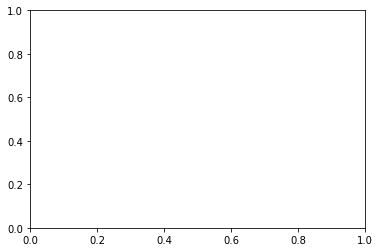

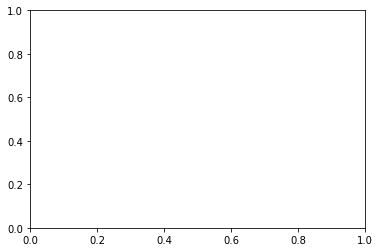

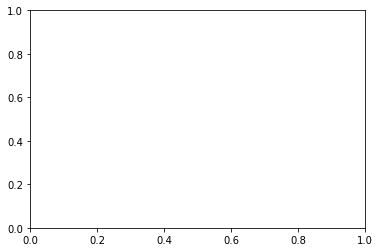

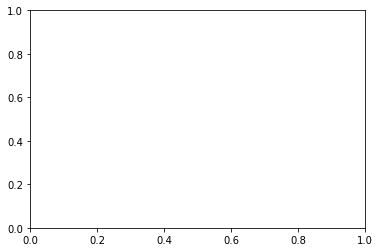

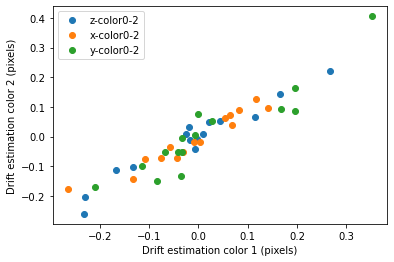

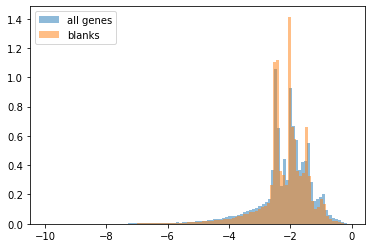

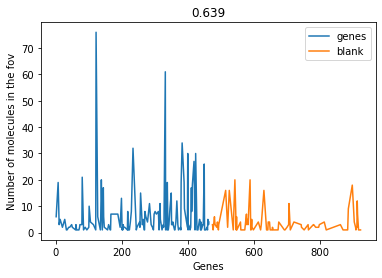

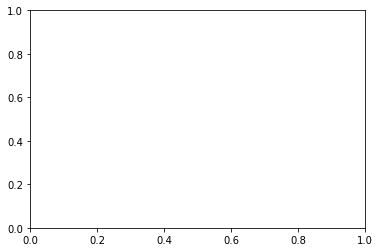

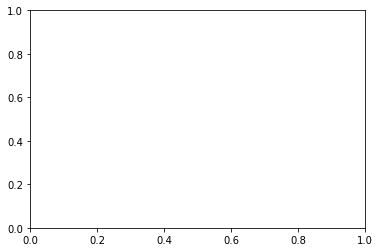

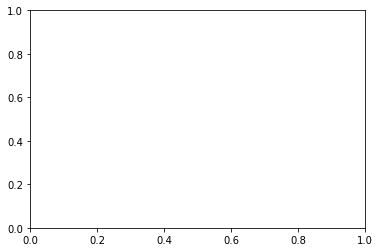

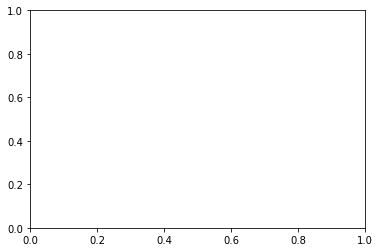

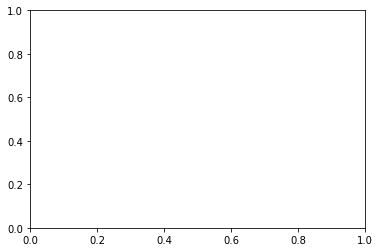

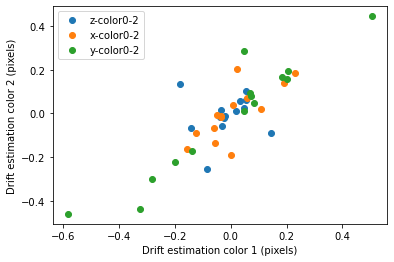

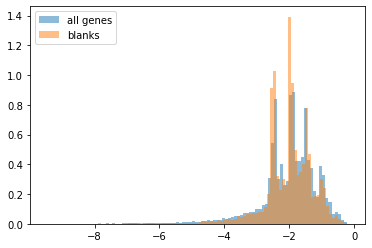

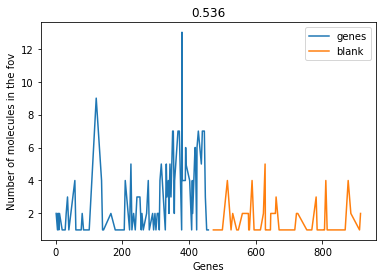

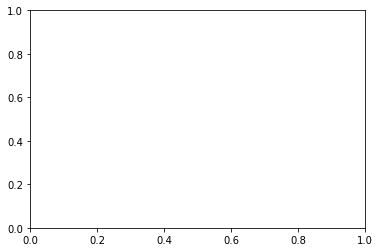

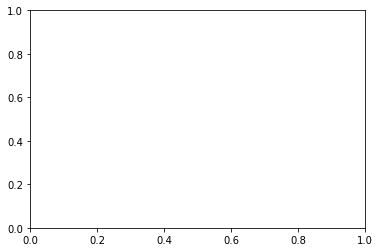

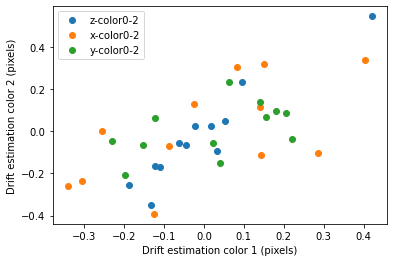

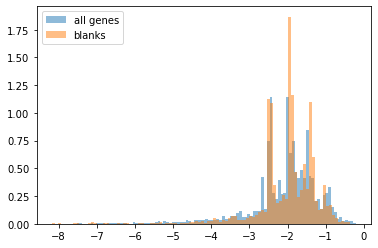

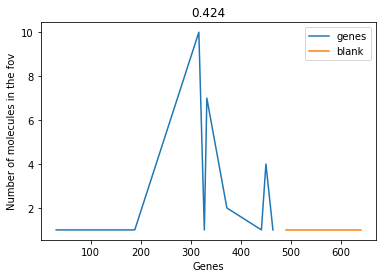

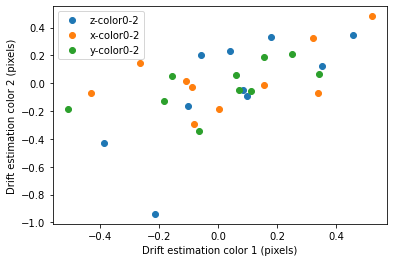

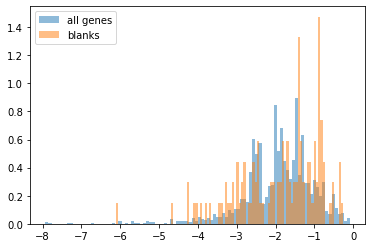

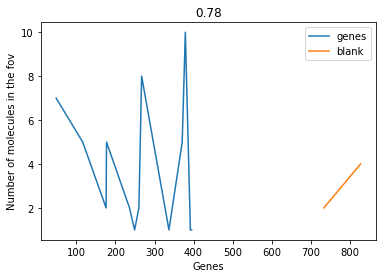

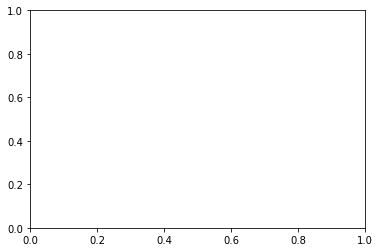

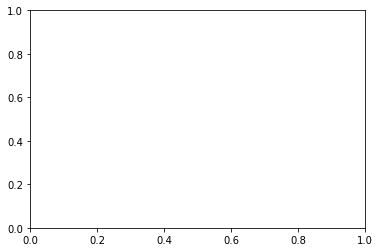

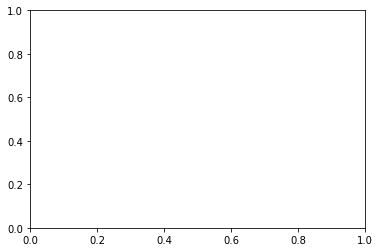

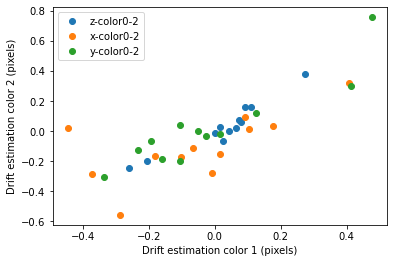

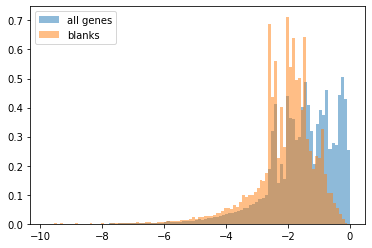

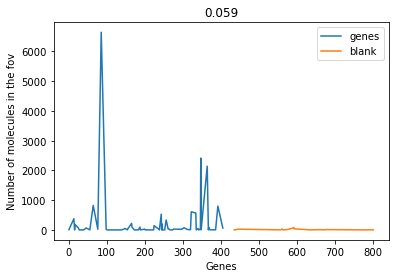

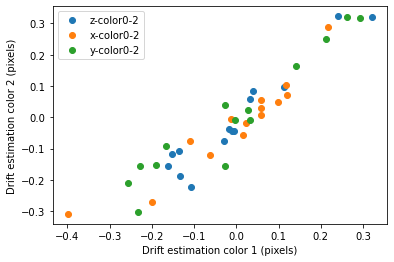

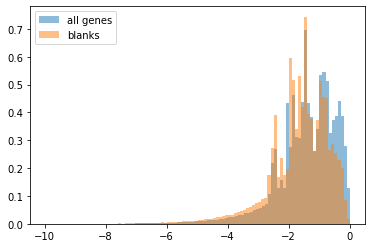

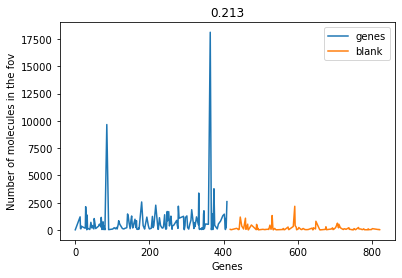

In [6]:
for fov,set_,save_folder in tqdm(paramaters[::-1]):
    try:
        main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98')
    except:
        print("Failed at:",fov,set_,save_folder)

### Load library information

In [7]:
tags_lib = ['-e1','-e2','-p12','-p34','-p56','-p711']
fls_lib = ['C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP1-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevEP2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP1P2-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP3P4-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP5P6-code_color2__comb16-4-4.csv',
 'C:\\Scripts\\NMERFISH\\codebooks\\blank_codebook_Mahsa_DevP7P11-code_color2__comb16-4-4.csv']
namesf = []
namesflib = []
for fl_l,tag_l in zip(fls_lib,tags_lib):
    dfL = pd.read_csv(fl_l)
    namesf+=[nm+tag_l if 'blank' in nm else nm for nm in dfL['name']]
    namesflib+=[nm+'--'+tag_l for nm in dfL['name']]
genesf = np.unique(namesf)
dic_nmlib_index = dict(zip(genesf,np.arange(len(genesf))))

dic_libs = {}
for gn in namesflib:
    gn_,lib_ = gn.split('---')[0],gn.split('---')[-1]
    if gn_ not in dic_libs: dic_libs[gn_]=[]
    dic_libs[gn_].append(lib_)


### Load the cell info first - fast

In [ ]:
save_fls_ = glob.glob(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--*')

In [ ]:
#dic_cells = {}
#dic_cells_alt={}
cells_all = None
keys = []
for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
   
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    base = os.path.basename(save_fl).split('--')[-2]+'_'
    keys.extend([base+str(int(cell)) for cell in cells[:,0]])
    cells_all = cells if cells_all is None else np.concatenate([cells_all,cells],axis=0)

    
volms = cells_all[:,1]
index = np.argsort(volms)[::1]
keys_ = np.array(keys)[index]
cells_all_=cells_all[index]
dice_cells = dict(zip(keys_,cells_all_))
keysF = np.array(list(dice_cells.keys()))
Xcells = np.array([dice_cells[cell][[0,-3,-2,-1]]for cell in keysF])

tree = cKDTree(Xcells)
res = tree.query_ball_tree(tree,20)
res_ = []
indCells = Xcells[:,0]

for ir,r in enumerate(tqdm(res)):
    ind_ = indCells[r]
    res_.append(np.array(r)[ind_==indCells[ir]])
dic_match={}
for ir,r in enumerate(res_):
    for r_ in r:
        dic_match[keysF[ir]]=keysF[r_]

### Load cell by gene in df

In [ ]:
#df will be of size genesf and cellidsf
#cell_df,df=None,None
dfF = None
cell_dfF = None
counter=0
dic_cells = {}
cellidsf = []
df = np.zeros([0,len(genesf)])

for save_fl in tqdm(save_fls_[:]):
    #save_fl = save_fls_[0]
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = list(dic['header_cells'])
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-0.5



    icell = header.index('cell_id')

    icells = XF[keep,icell].astype(int)
    vols = cells[:,header_cells.index('volm')]

    icellsf = cells[:,0].astype(int)
    vols = cells[:,header_cells.index('volm')]
    
    vol_th_ = vols>4000
    icellsf = icellsf[vol_th_]
    cells = cells[vol_th_]
    
    
    
    
    keep_vol = np.in1d(icells,icellsf) ### is molecule part of a big enough cell
    icells=icells[keep_vol] #final cell indexes of the molecules
    
    base_cell = os.path.basename(save_fl).split('--')[-2]+'_'
    icells_match = np.array([dic_match[base_cell+str(int(icell))]for icell in icells])
    
    ugns,gns_i = np.unique(genes_decoded[keep][keep_vol],return_inverse=True)
    
    
    
    icells_unique,icells_inv = np.unique(icells_match,return_inverse=True)
    #icells_unique = list(icells_unique)+list(np.setdiff1d(icellsf,icells_unique))### add back in the 0 count cells
    #icells_unique = np.array(icells_unique)
    mcell = len(icells_unique)#+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells_inv,return_counts=True)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts
    
    _,plate,fov,set_ = os.path.basename(save_fl).split('--')
    plate = plate.lower().split('analysis')[-1]
    ugns_ = [gn+'-'+plate if 'blank' in gn else gn for gn in ugns]
    igns = [dic_nmlib_index[gn] for gn in ugns_]
    
    #icells_unique
    in_common_cells = np.in1d(icells_unique,cellidsf)#,assume_unique=True)
    cellidsf_dic = dict(zip(cellidsf,np.arange(len(cellidsf))))
    in_common_cells_f = np.array([cellidsf_dic[cell_] for cell_ in icells_unique[in_common_cells]],dtype=int)
    #in_common_cells_f = np.in1d(cellidsf,icells_unique)#,assume_unique=True)
    vals = np.zeros([np.sum(in_common_cells),len(genesf)])
    prev_vals = df[in_common_cells_f][:,igns]
    vals[:,igns] = np.max([Mcts[in_common_cells],prev_vals],axis=0)
    if np.sum(in_common_cells_f)>0:
        df[in_common_cells_f] = np.max([vals,df[in_common_cells_f]],axis=0)
    
    #df[in_common_cells_f][:,igns] = np.max([df[in_common_cells_f][:,igns],Mcts[in_common_cells]],axis=0)
    not_in_common_cells = ~in_common_cells
    extra_df = np.zeros([np.sum(not_in_common_cells),len(genesf)])
    extra_df[:,igns]=Mcts[not_in_common_cells]
    df = np.concatenate([df,extra_df])
    cellidsf+=list(icells_unique[not_in_common_cells])
    

### Save dataframes

In [ ]:

len(cellidsf)
dff = pd.DataFrame(df,columns=genesf,index=cellidsf)
cell_df = np.array([dice_cells.get(cell,[0]*len(header_cells)) for cell in cellidsf])
cell_df = pd.DataFrame(cell_df,columns=header_cells,index=cellidsf)
dff.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df.to_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

### Load and visiualize dataframes

In [9]:
import sys
sys.path.append(r'..//')
from ioMicro import *
import pandas as pd

In [10]:
dff = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\dff_D16_0p5th.pkl')
cell_df = pd.read_pickle(r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DataFrames\cell_df_D16_0p5th.pkl')

In [27]:
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20,viewer=None):
    cell_df_ = cell_df
    xcells,ycells=cell_df_['x_um_abs'],cell_df_['y_um_abs']
    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    vols = cell_df_['volm']
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    cts[np.isnan(cts)]=0
    cts = cts/vols*np.median(vols)
    
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    good_cells = np.argsort(cts)
    names_cells = np.array(list(dff.index))[good_cells]
    XC = -Xcells[good_cells,::-1]
    if viewer is None:
        viewer = napari.view_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    else:
        viewer.add_points(XC,size=size[good_cells],face_color=cols[good_cells],name=gene)
    if plt_fov:
        #ifovs = np.array(list(df.index),dtype=int)//10**5
        ifovs = [int(nm.split('_')[-2]) for nm in names_cells]
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        features =  {'fov':ifov_unk}
        text = {
            'string': '{fov:.0f}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)
    return viewer

In [36]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
#gene = 'Aif1'
#viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20);
gene = 'P2ry12'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
gene = 'Csf1r'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Tmem119'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
gene = 'Cx3cr1'
viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20,viewer=viewer)
if False:
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [24]:
gns_all = np.sort([gn for gn in dff.columns if 'blank' not in gn])
print(list(gns_all))

['1110008P14Rik', '1500015O10Rik', '1810041L15Rik', '2310069B03Rik', '2610528A11Rik', '2900055J20Rik', '3110035E14Rik', '4833407H14Rik', '4930570B17Rik', '6330403K07Rik', '9630013A20Rik', 'A1cf', 'A230050P20Rik', 'A830009L08Rik', 'A930003A15Rik', 'Abca8a', 'Abcb1b', 'Abcb4', 'Abcg1', 'Abhd15', 'Abhd2', 'Abi3', 'Abi3bp', 'Acer3', 'Ache', 'Acsl3', 'Acta2', 'Actg1', 'Adamts1', 'Adamts5', 'Adamts9', 'Adamtsl4', 'Adarb2', 'Adcy1', 'Adcy2', 'Adcyap1', 'Adgra2', 'Adgrd1', 'Adgre1', 'Adgrl3', 'Adh1', 'Adora2a', 'Adora3', 'Afap1l2', 'Afp', 'Agpat2', 'Agrp', 'Agt', 'Ahcyl2', 'Ahi1', 'Ahnak', 'Aif1', 'Aif1l', 'Akain1', 'Alas2', 'Alb', 'Aldh1a1', 'Aldh1a2', 'Aldh1a7', 'Aldh1l1', 'Aldoa', 'Aldoc', 'Alox12', 'Alox5ap', 'Alx1', 'Alyref', 'Ambra1', 'Amd2', 'Amot', 'Amz1', 'Angpt1', 'Ank2', 'Ankk1', 'Ankrd11', 'Anks6', 'Anln', 'Anp32e', 'Anxa2', 'Anxa5', 'Aoah', 'Ap3s1', 'Apln', 'Apoa1', 'Apoa2', 'Apoc2', 'Apod', 'Apoe', 'Apoo', 'Aqp1', 'Aqp2', 'Aqp3', 'Aqp4', 'Aqp8', 'Arg1', 'Arhgap10', 'Arhgap27', 'A

In [37]:
len(gns_all)

2042

In [42]:
svfld =r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\images'
if not os.path.exists(svfld): os.makedirs(svfld)
    
gene = 'Acsl'
for gene in [gn for gn in gns_all if 'Foxj1' in gn]:
#for gene in ['Malat1', 'H19', 'Col1a1', 'Dpysl3', 'Meg3', 'Ptprs', 'Mapt', 'Dpysl2', 'Gnb1', 'Ywhae', 'Col3a1', 'Sox4', 'Nfix', 'Serpinh1', 'Sparc', 'Agt', 'Nedd4', 'Nnat', 'Ina', 'Xist', 'Uchl1', 'Islr2', 'Igfbpl1', 'Elavl3', 'Sdc3', 'Rab6b', 'Gpm6a', 'Cntf', 'Ndn', 'Csdc2']:
    viewer = plot_gene_mosaic_cells(dff,cell_df,gene,plt_fov=False,transpose=1,flipx=1,flipy=1,sz_min=5,sz_max=10,nmax=20)
    im = viewer.screenshot(size=(5000,5000))
    viewer.close()
    cv2.imwrite(svfld+os.sep+gene+'_D16.png',im[:,:,[2,1,0,3]])

In [32]:
'Tmem119' in gns_all

True

In [ ]:
TMEM119